<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Lab: Building Advanced Transformers**

**Estimated time needed:  30 minutes**  

In this lab, you will implement and experiment with advanced Transformer models using Keras. 

**Learning objectives:** 

By the end of this lab, you will be able to:

- Understand the core components of a Transformer architecture.
- Implement a multi-head self-attention mechanism from scratch.
- Train and evaluate a Transformer for time series prediction.
- Handle preprocessing and scaling for time series data effectively.


## What is a Transformer?

The Transformer architecture was introduced in the paper *"Attention Is All You Need"*. It revolutionized natural language processing by using attention mechanisms instead of recurrence.

### Key Components:
- **Input Embedding:** Converts input tokens (or time steps) into vectors.
- **Positional Encoding:** Injects information about the position of input tokens.
- **Multi-Head Self-Attention:** Allows the model to focus on different parts of the input sequence.
- **Feedforward Layers:** Process the attended information.
- **Layer Normalization & Residual Connections:** Stabilize and speed up training.

> Transformers are now widely used not only in NLP but also in time series forecasting, image recognition, and more.

**Next:** You will implement parts of this architecture step-by-step.


## Step-by-Step Instructions: 

### Step 1: Import necessary libraries 

Before you start, you need to import the required libraries: TensorFlow and Keras. Keras is included within TensorFlow as `tensorflow.keras.`


In [1]:
%pip install tensorflow pyarrow 
%pip install pandas  
%pip install scikit-learn 
%pip install matplotlib 
%pip install requests



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB ? eta 0:00:00 0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 20.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 67.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 50.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 48.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 48.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 57.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 53.7 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/1

In [2]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import requests
from sklearn.preprocessing import MinMaxScaler 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

2026-02-21 14:56:34.643470: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-21 14:56:34.643985: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-21 14:56:34.707948: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-21 14:56:36.334301: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

####  Setup the Environment to generate synthetic stock price data


In [3]:
import numpy as np
import pandas as pd

# Create a synthetic stock price dataset
np.random.seed(42)
data_length = 2000  # Adjust data length as needed
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a DataFrame and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
print("Synthetic stock_prices.csv created and loaded.")


Synthetic stock_prices.csv created and loaded.


In [4]:
# Load the dataset 
data = pd.read_csv('stock_prices.csv') 
data = data[['Close']].values 

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare the data for training
def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape) 
print("Shape of Y:", Y.shape) 

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


In the above code: 

`tensorflow` is the main library for machine learning in Python.  

`stock_prices.csv` is the data set that is loaded. 

`MinMaxScaler` method is used to normalize the data.  

`create_dataset`method is used to prepare the data for training. 


### Step 2: Implement Multi-Head Self-Attention 

Define the Multi-Head Self-Attention mechanism. 


In [5]:
class MultiHeadSelfAttention(Layer): 

    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 


    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 

    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 

    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

 

In the above code: 

- The MultiHeadSelfAttention layer implements the multi-head self-attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously. 

- The attention parameter computes the attention scores and weighted sum of the values. 

- The split_heads parameter splits the input into multiple heads for parallel attention computation. 

- The call method applies the self-attention mechanism and combines the heads.


# MultiHeadSelfAttention 完整讲解（含代码 + 汉语解释）

这个类实现的是 **Transformer 中的多头自注意力机制（Multi-Head Self-Attention）**。

它的作用是：

> 让序列中的每一个 token 都能与所有 token 进行信息交互。

输入和输出形状相同：

```
(batch_size, seq_len, embed_dim)
→
(batch_size, seq_len, embed_dim)
```

---

# 一、完整代码

```python
class MultiHeadSelfAttention(Layer):

    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]

        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        attention, _ = self.attention(query, key, value)

        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))

        output = self.combine_heads(concat_attention)
        return output
```

---

# 二、结构总览

整个流程可以分为 5 步：

1. 线性映射得到 Q、K、V  
2. 拆分为多个 head  
3. 每个 head 计算 attention  
4. 拼接所有 head  
5. 再做一次线性映射输出  

---

# 三、初始化阶段 (__init__)

## 参数

- `embed_dim`：embedding 总维度  
- `num_heads`：注意力头数量  

### 每个头的维度

```
projection_dim = embed_dim // num_heads
```

例如：

```
embed_dim = 512
num_heads = 8
projection_dim = 64
```

说明每个 head 处理 64 维。

---

## Q, K, V 线性变换

```
Q = XW_Q
K = XW_K
V = XW_V
```

形状：

```
(batch, seq_len, embed_dim)
```

---

# 四、拆分为多头

原始：

```
(batch, seq_len, embed_dim)
```

reshape 后：

```
(batch, seq_len, num_heads, projection_dim)
```

transpose 后：

```
(batch, num_heads, seq_len, projection_dim)
```

这样每个 head 就可以独立计算注意力。

---

# 五、Attention 计算过程

## 1️⃣ 点积

```
score = QK^T
```

得到：

```
(batch, heads, seq_len, seq_len)
```

表示每个 token 对所有 token 的相似度。

---

## 2️⃣ 缩放

```
scaled_score = score / sqrt(d_k)
```

防止维度过大导致 softmax 不稳定。

---

## 3️⃣ Softmax

公式：

\[
Attention(Q,K,V) = softmax(QK^T / \sqrt{d_k}) V
\]

得到权重矩阵。

---

## 4️⃣ 加权求和

```
output = weights V
```

输出：

```
(batch, heads, seq_len, projection_dim)
```

---

# 六、多头拼接

transpose 回来：

```
(batch, seq_len, heads, projection_dim)
```

reshape：

```
(batch, seq_len, embed_dim)
```

再做一次线性变换：

```
output = Concat(heads) W^O
```

---

# 七、完整数学表达

\[
MultiHead(Q,K,V) = Concat(head_1,...,head_h) W^O
\]

其中：

\[
head_i = Attention(QW_i^Q, KW_i^K, VW_i^V)
\]

---

# 八、时间复杂度

```
O(seq_len^2)
```

因为每个 token 都要和所有 token 计算相似度。

这是 Transformer 最大瓶颈。

---

# 九、直观理解

可以把 attention 理解为：

> 一个动态学习的影响矩阵

每一行代表一个 token 对所有 token 的加权组合。

如果放到多智能体系统里，它就是：

> 自适应的 agent 之间影响权重矩阵

---

# 十、工程说明

这个实现是教学版本：

- 没有 mask  
- 没有 dropout  
- 没有 causal mask  
- 没有缓存优化  

实际工程中一般使用：

```python
tf.keras.layers.MultiHeadAttention
```

---

如果你需要，我可以再补：

- causal mask 版本  
- 带位置编码的完整 Transformer Block  
- FlashAttention 优化原理  
- 或者从矩阵代数角度做严格推导


### Step 3: Implement Transformer block 

Define the Transformer block. 


In [6]:
class TransformerBlock(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 


    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

In the above code:

- The TransformerBlock layer combines multi-head self-attention with a feed-forward neural network and normalization layers.  

- Dropout is used to prevent overfitting. 

- The call method applies the self-attention, followed by the feedforward network with residual connections and layer normalization.



# TransformerBlock 结构完整讲解

这个 `TransformerBlock` 实现的是 **标准 Transformer Encoder Block**。

它由四个核心组件构成：

- Multi-Head Self-Attention
- 前馈网络（Feed Forward Network, FFN）
- 残差连接（Residual Connection）
- Layer Normalization

输入输出形状保持一致：

```
(batch_size, seq_len, embed_dim)
→
(batch_size, seq_len, embed_dim)
```

---

# 一、完整代码

```python
class TransformerBlock(Layer):

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)

        return self.layernorm2(out1 + ffn_output)
```

---

# 二、整体结构概览

整个流程分为 6 步：

1. Self-Attention
2. Dropout
3. 残差连接 + LayerNorm
4. 前馈网络（FFN）
5. Dropout
6. 残差连接 + LayerNorm

可以写成数学形式：

\[
X_1 = LN(X + Attention(X))
\]

\[
Output = LN(X_1 + FFN(X_1))
\]

---

# 三、Attention 部分

```python
attn_output = self.att(inputs)
```

这是 token 之间的信息交互。

Attention 本质是：

\[
Attention(Q,K,V) = softmax\left(\frac{QK^T}{\sqrt{d_k}}\right)V
\]

它生成一个动态的权重矩阵，让每个 token 重新组合所有 token 的信息。

---

# 四、残差连接（Residual Connection）

```python
out1 = self.layernorm1(inputs + attn_output)
```

残差连接的形式是：

\[
X + Attention(X)
\]

作用：

- 防止梯度消失
- 允许网络退化为恒等映射
- 使深层堆叠成为可能

如果没有残差，Transformer 很难训练深层模型。

---

# 五、Layer Normalization

LayerNorm 对每个 token 的 embedding 维度做归一化：

\[
LN(x) = \frac{x - \mu}{\sigma} \gamma + \beta
\]

作用：

- 稳定数值尺度
- 加快收敛
- 防止梯度爆炸

不同于 BatchNorm，它不依赖 batch 统计量。

---

# 六、前馈网络（FFN）

```python
self.ffn = tf.keras.Sequential([
    Dense(ff_dim, activation="relu"),
    Dense(embed_dim),
])
```

结构：

```
embed_dim → ff_dim → embed_dim
```

通常：

```
ff_dim = 4 * embed_dim
```

作用：

- 对每个 token 独立做非线性变换
- 增强表达能力

注意：

- Attention 负责 token 之间交互
- FFN 负责 token 内部变换

如果没有 FFN，整个结构会接近线性系统。

---

# 七、第二次残差 + LayerNorm

```python
return self.layernorm2(out1 + ffn_output)
```

数学形式：

\[
Output = LN(X_1 + FFN(X_1))
\]

再次稳定训练，并允许模型在深层中保持信息流动。

---

# 八、信息流直观图

```
         ┌────────────────────┐
         │ MultiHeadAttention │
         └──────────┬─────────┘
                    ↓
           Residual + LayerNorm
                    ↓
         ┌────────────────────┐
         │        FFN         │
         └──────────┬─────────┘
                    ↓
           Residual + LayerNorm
```

---

# 九、复杂度分析

Attention 复杂度：

\[
O(seq_len^2)
\]

FFN 复杂度：

\[
O(seq_len · embed_dim · ff_dim)
\]

通常 Attention 是主要瓶颈。

---

# 十、系统视角理解

整个 Block 可以写成一个非线性迭代系统：

\[
X_{t+1} = LN(X_t + A(X_t))
\]

\[
X_{t+2} = LN(X_{t+1} + F(X_{t+1}))
\]

其中：

- \( A(X) \) 是动态生成的注意力矩阵
- \( F(X) \) 是逐 token 的非线性映射

堆叠多个 TransformerBlock，本质是：

> 多次“全局信息重组 + 局部非线性更新”

---

# 十一、更抽象理解

如果把 token 看成 agent：

- Attention = 动态生成的影响矩阵
- FFN = agent 内部状态更新

那么 TransformerBlock 就是：

> 一轮网络互动 + 一轮个体策略更新

这是一个动态耦合系统。

---

# 十二、核心总结

TransformerBlock =

- 动态交互结构（Attention）
- 局部非线性变换（FFN）
- 稳定训练机制（Residual + LayerNorm）

它是 Transformer 可堆叠、可扩展、可深层训练的核心单元。

### Step 4: Implement Encoder Layer 

Define the Encoder layer. 


In [7]:
class EncoderLayer(Layer): 

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(EncoderLayer, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 

 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 



In the above code: 

- The EncoderLayer is similar to the TransformerBlock but is a reusable layer in the Transformer architecture. 

- It consists of a MultiHeadSelfAttention mechanism followed by a feedforward neural network. 

- Both sub-layers have residual connections around them, and layer normalization is applied to the output of each sub-layer. 

- The call method applies the self-attention, followed by the feedforward network, with residual connections and layer normalization. 


### Step 5: Implement Transformer encoder 

Define the Transformer Encoder. 


In [8]:
import tensorflow as tf 
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout 

class MultiHeadSelfAttention(Layer): 
    def __init__(self, embed_dim, num_heads=8): 
        super(MultiHeadSelfAttention, self).__init__() 
        self.embed_dim = embed_dim 
        self.num_heads = num_heads 
        self.projection_dim = embed_dim // num_heads 
        self.query_dense = Dense(embed_dim) 
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim) 
        self.combine_heads = Dense(embed_dim) 
 

    def attention(self, query, key, value): 
        score = tf.matmul(query, key, transpose_b=True) 
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32) 
        scaled_score = score / tf.math.sqrt(dim_key) 
        weights = tf.nn.softmax(scaled_score, axis=-1) 
        output = tf.matmul(weights, value) 
        return output, weights 


    def split_heads(self, x, batch_size): 
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim)) 
        return tf.transpose(x, perm=[0, 2, 1, 3]) 


    def call(self, inputs): 
        batch_size = tf.shape(inputs)[0] 
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs) 
        value = self.value_dense(inputs) 
        query = self.split_heads(query, batch_size) 
        key = self.split_heads(key, batch_size) 
        value = self.split_heads(value, batch_size) 
        attention, _ = self.attention(query, key, value) 
        attention = tf.transpose(attention, perm=[0, 2, 1, 3]) 
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim)) 
        output = self.combine_heads(concat_attention) 
        return output 

class TransformerBlock(Layer): 
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerBlock, self).__init__() 
        self.att = MultiHeadSelfAttention(embed_dim, num_heads) 
        self.ffn = tf.keras.Sequential([ 
            Dense(ff_dim, activation="relu"), 
            Dense(embed_dim), 
        ]) 

        self.layernorm1 = LayerNormalization(epsilon=1e-6) 
        self.layernorm2 = LayerNormalization(epsilon=1e-6) 
        self.dropout1 = Dropout(rate) 
        self.dropout2 = Dropout(rate) 
 

    def call(self, inputs, training): 
        attn_output = self.att(inputs) 
        attn_output = self.dropout1(attn_output, training=training) 
        out1 = self.layernorm1(inputs + attn_output) 
        ffn_output = self.ffn(out1) 
        ffn_output = self.dropout2(ffn_output, training=training) 
        return self.layernorm2(out1 + ffn_output) 

class TransformerEncoder(Layer): 
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1): 
        super(TransformerEncoder, self).__init__() 
        self.num_layers = num_layers 
        self.embed_dim = embed_dim 
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)] 
        self.dropout = Dropout(rate) 

    def call(self, inputs, training=False): 
        x = inputs 
        for i in range(self.num_layers): 
            x = self.enc_layers[i](x, training=training) 
        return x 

# Example usage 
embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 
inputs = tf.random.uniform((1, 100, embed_dim)) 
outputs = transformer_encoder(inputs, training=False)  # Use keyword argument for 'training' 
print(outputs.shape)  # Should print (1, 100, 128) 

2026-02-21 14:56:38.343732: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


(1, 100, 128)


In the above code: 

The TransformerEncoder is composed of multiple TransformerBlock layers, implementing the encoding part of the Transformer architecture. 


### Step 6: Build and Compile the Transformer model 

Integrate the Transformer Encoder into a complete model for sequential data. 


In [9]:
# Define the necessary parameters 

embed_dim = 128 
num_heads = 8 
ff_dim = 512 
num_layers = 4 

# Define the Transformer Encoder 
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim) 

# Build the model 
input_shape = (X.shape[1], X.shape[2]) 
inputs = tf.keras.Input(shape=input_shape) 

# Project the inputs to the embed_dim 
x = tf.keras.layers.Dense(embed_dim)(inputs) 
encoder_outputs = transformer_encoder(x) 
flatten = tf.keras.layers.Flatten()(encoder_outputs) 
outputs = tf.keras.layers.Dense(1)(flatten) 
model = tf.keras.Model(inputs, outputs) 

# Compile the model 
model.compile(optimizer='adam', loss='mse') 

# Summary of the model 
model.summary() 


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In the above code: 

- The Transformer Encoder model defines the necessary parameters, flattens the output, and ends with a dense layer to produce the final output.  

- The model is then compiled with the Adam optimizer and mean squared error loss. 


### Step 7: Train the Transformer model 

Train the model on the prepared dataset. 


In [10]:
# Train the model
model.fit(X, Y, epochs=20, batch_size=32)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 3.2833  
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.2043 
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.1790 
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.1841 
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 0.1474 
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.1502 
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.1604 
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 0.1468 
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 75s 1s/step - loss: 0.0997 
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 0.1010 
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.0993 
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.0963 
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.1058 
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 0.0850 
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 0.0867 
Epo

In the above code: 

The model is trained on the normalized stock price data for 20 epochs with a batch size of 32. 


### Step 8: Evaluate and Make Predictions 

Evaluate the model's performance and make predictions on the dataset. 


60/60 ━━━━━━━━━━━━━━━━━━━━ 21s 336ms/step


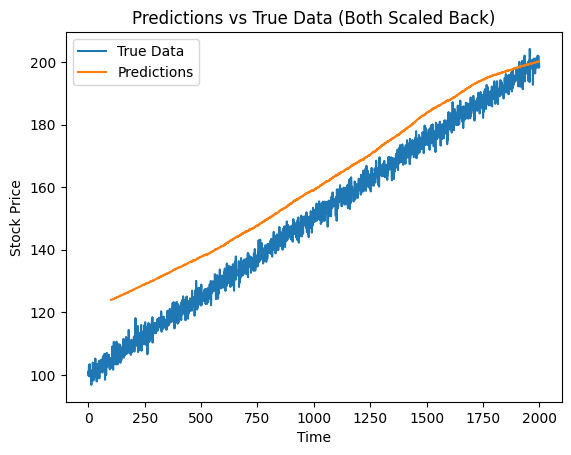

In [11]:
# Make predictions 
predictions = model.predict(X) 
predictions = scaler.inverse_transform(predictions) 

# Prepare true values for comparison
true_values = scaler.inverse_transform(data.reshape(-1, 1))

# Plot the predictions vs true values
import matplotlib.pyplot as plt 

plt.plot(true_values, label='True Data') 
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions') 
plt.xlabel('Time') 
plt.ylabel('Stock Price') 
plt.legend() 
plt.title('Predictions vs True Data (Both Scaled Back)')
plt.show() 


In the above code: 

- The model's predictions are transformed back to the original scale using the inverse transform of the scaler. 

- The true data and predictions are plotted to visualize the model's performance. 


## Practice Exercises: 

 ### Exercise 1: Add dropout to the Transformer model 

 **Objective: Understand how to add dropout layers to the Transformer model to prevent overfitting.** 

 Instructions: 

- Add a dropout layer after the Flatten layer in the model. 

- Set the dropout rate to 0.5. 


In [12]:
## Write your code here.
from tensorflow.keras.layers import Dropout 

  

# Add a dropout layer after the Flatten layer 

flatten = tf.keras.layers.Flatten()(encoder_outputs) 

dropout = Dropout(0.5)(flatten) 

outputs = tf.keras.layers.Dense(1)(dropout) 

  

# Build the model 

model = tf.keras.Model(inputs, outputs) 

  

# Compile the model 

model.compile(optimizer='adam', loss='mse') 

  

# Train the model 

model.fit(X, Y, epochs=20, batch_size=32) 

  

# Evaluate the model 

loss = model.evaluate(X, Y) 

print(f'Test loss: {loss}') 

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step - loss: 3.3423  
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 1.0807 
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - loss: 0.6744 
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - loss: 0.3697 
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 0.1394 
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 0.0693 
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 0.0431 
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.0327 
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.0235 
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.0208 
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - loss: 0.0191 
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.0163 
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.0144 
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.0156 
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 66s 1s/step - loss: 0.0136 
Epo

<details><summary>Click here to view the solution.</summary>

```
from tensorflow.keras.layers import Dropout 

  

# Add a dropout layer after the Flatten layer 

flatten = tf.keras.layers.Flatten()(encoder_outputs) 

dropout = Dropout(0.5)(flatten) 

outputs = tf.keras.layers.Dense(1)(dropout) 

  

# Build the model 

model = tf.keras.Model(inputs, outputs) 

  

# Compile the model 

model.compile(optimizer='adam', loss='mse') 

  

# Train the model 

model.fit(X, Y, epochs=20, batch_size=32) 

  

# Evaluate the model 

loss = model.evaluate(X, Y) 

print(f'Test loss: {loss}') 

```
</details>


### Exercise 2: Experiment with different batch sizes 

**Objective: Observe the impact of different batch sizes on model performance.** 

 Instructions: 

- Train the model with a batch size of 16. 

- Train the model with a batch size of 64. 

- Compare the training time and performance. 


In [ ]:
## Write your code here.
# Train the model with batch size 16
model.fit(X, Y, epochs=20, batch_size=16)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 16: {loss}')

# Train the model with batch size 64
model.fit(X, Y, epochs=20, batch_size=64)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 64: {loss}')

Epoch 1/20
 31/119 ━━━━━━━━━━━━━━━━━━━━ 55s 635ms/step - loss: 0.0123 

<details><summary>Click here to view the solution.</summary>

```
# Train the model with batch size 16
model.fit(X, Y, epochs=20, batch_size=16)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 16: {loss}')

# Train the model with batch size 64
model.fit(X, Y, epochs=20, batch_size=64)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 64: {loss}')

```
</details>


### Exercise 3: Use a different activation function 

 **Objective: Understand how different activation functions impact the model performance.** 

 Instructions: 

- Change the activation function of the Dense layer to `tanh`. 

- Train and evaluate the model. 


In [ ]:
## Write your code here.
# Change the activation function of the Dense layer to tanh
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

<details><summary>Click here to view the solution.</summary>

```
# Change the activation function of the Dense layer to tanh
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

```
</details>


## Conclusion
Congratulations on completing this lab! In this lab, you have built an advanced Transformer model using Keras and applied it to a time series forecasting task. You have learned how to define and implement multi-head self-attention, Transformer blocks, encoder layers, and integrate them into a complete Transformer model. By experimenting with different configurations and training the model, you can further improve its performance and apply it to various sequential data tasks. 


Copyright © IBM Corporation. All rights reserved.
